# Read data and create timeseries using PICES LME

Look at SST, ocean currents, chl-a

In [27]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

def weighted_mean_of_masked_data(data_in,data_mask,data_cond):
    #data_in = input xarray data to have weighted mean
    #data_mask = nan mask eg. land values
    #LME mask T or F values
    R = 6.37e6 #radius of earth in m
    grid_dy,grid_dx = (data_in.lat[0]-data_in.lat[1]).data,(data_in.lon[0]-data_in.lon[1]).data
    dϕ = np.deg2rad(grid_dy)
    dλ = np.deg2rad(grid_dx)
    dA = R**2 * dϕ * dλ * np.cos(np.deg2rad(ds.lat)) 
    pixel_area = dA.where(data_cond)  #pixel_area.plot()
    pixel_area = pixel_area.where(np.isfinite(data_mask))
    total_ocean_area = pixel_area.sum(dim=('lon', 'lat'))
    data_weighted_mean = (data_in * pixel_area).sum(dim=('lon', 'lat')) / total_ocean_area
    return data_weighted_mean

def weighted_mean_of_data(data_in,data_cond):
    #data_in = input xarray data to have weighted mean
    #data_mask = nan mask eg. land values
    #LME mask T or F values
    R = 6.37e6 #radius of earth in m
    grid_dy,grid_dx = (data_in.lat[0]-data_in.lat[1]).data,(data_in.lon[0]-data_in.lon[1]).data
    dϕ = np.deg2rad(grid_dy)
    dλ = np.deg2rad(grid_dx)
    dA = R**2 * dϕ * dλ * np.cos(np.deg2rad(ds.lat)) 
    pixel_area = dA.where(data_cond)  #pixel_area.plot()
    #pixel_area = pixel_area.where(np.isfinite(data_mask))
    total_ocean_area = pixel_area.sum(dim=('lon', 'lat'))
    data_weighted_mean = (data_in * pixel_area).sum(dim=('lon', 'lat')) / total_ocean_area
    return data_weighted_mean


# Read in PICES mask

- Each dataset finds a unique and different way to define lat / lon or order them.
- There is a need for standardization in this area
- The basic PICES mask is -180 to 180 lon and -90 to 90 lat
- Below different maps are created for 0 to 360 lon
- Then each of the two different lon maps are also copied to reverse lat, 90 to -90

In [87]:
#read in mask file
filename = './data/PICES_all_mask.nc'
ds_pices = xr.open_dataset(filename)
ds_pices.close()
#read in mask file
filename = './data/PICES_all_mask360.nc'
ds_pices360 = xr.open_dataset(filename)
ds_pices360.close()

ds_pices_revlat = ds_pices.sortby(ds_pices.lat, ascending = False)
ds_pices360_revlat = ds_pices360.sortby(ds_pices360.lat, ascending = False)



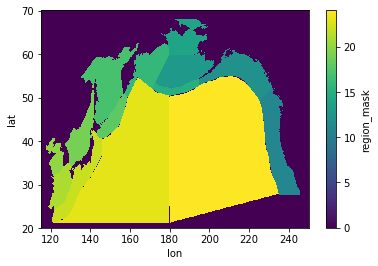

In [101]:
ds_pices360.sel(lon=slice(115,250),lat=slice(20,70)).region_mask.plot()

## Read in SST data

In [90]:
ds = xr.open_dataset('./data/sst.mnmean.nc')
print('lat range',ds.lat[0].data,ds.lat[-1].data)
print('lon range',ds.lon[0].data,ds.lon[-1].data)
#create sst mean for pices region
iregion=13
mask_interp = ds_pices360_revlat.interp_like(ds,method='nearest')
cond = (mask_interp.region_mask==iregion)
sst_mean = weighted_mean_of_data(ds.sst,cond)

#make climatology and anomalies using .groupby method
sst_climatology = sst_mean.groupby('time.month').mean('time')
sst_anomalies = sst_mean.groupby('time.month') - sst_climatology

lat range 89.5 -89.5
lon range 0.5 359.5


## Read in wind data

In [92]:
aggr_url = 'https://coastwatch.pfeg.noaa.gov/erddap/griddap/erdlasFnWind10'
ds = xr.open_dataset(aggr_url).rename({'latitude':'lat','longitude':'lon'}).drop({'taux_mean','tauy_mean','curl'})
print('lat range',ds.lat[0].data,ds.lat[-1].data)
print('lon range',ds.lon[0].data,ds.lon[-1].data)

#create  mean for pices region
iregion=13
mask_interp = ds_pices360.interp_like(ds,method='nearest')
cond = (mask_interp.region_mask==iregion)
wnd_mean = weighted_mean_of_data(ds,cond)

#make climatology and anomalies using .groupby method
wnd_climatology = wnd_mean.groupby('time.month').mean('time')
wnd_anomalies = wnd_mean.groupby('time.month') - wnd_climatology


lat range -90.0 90.0
lon range 0.0 359.0


## Testing still

In [93]:
aggr_url = 'https://coastwatch.pfeg.noaa.gov/erddap/griddap/pmlEsaCCI31OceanColorMonthly'
ds = xr.open_dataset(aggr_url).rename({'latitude':'lat','longitude':'lon'})
print('lat range',ds.lat[0].data,ds.lat[-1].data)
print('lon range',ds.lon[0].data,ds.lon[-1].data)

#create  mean for pices region
iregion=13
mask_interp = ds_pices_revlat.interp_like(ds,method='nearest')
cond = (mask_interp.region_mask==iregion)
chl_mean = weighted_mean_of_data(ds,cond)

#make climatology and anomalies using .groupby method
chl_climatology = chl_mean.groupby('time.month').mean('time')
chl_anomalies = chl_mean.groupby('time.month') - chl_climatology


lat range 89.979164 -89.979164
lon range -179.97917 179.97917


In [ ]:
aggr_url = 'https://coastwatch.pfeg.noaa.gov/erddap/griddap/jplOscar'
ds = xr.open_dataset(aggr_url).isel(depth=0).rename({'latitude':'lat','longitude':'lon'}).drop({'um','vm'})
print('lat range',ds.lat[0].data,ds.lat[-1].data)
print('lon range',ds.lon[0].data,ds.lon[-1].data)

ds = ds.sel(lon=slice(115,250),lat=slice(70,20))

#create  mean for pices region
iregion=13
mask_interp = ds_pices360_revlat.interp_like(ds,method='nearest')
cond = (mask_interp.region_mask==iregion)
cur_mean = weighted_mean_of_data(ds,cond)

#make climatology and anomalies using .groupby method
cur_climatology = cur_mean.groupby('time.month').mean('time')
cur_anomalies = cur_mean.groupby('time.month') - cur_climatology


lat range 80.0 -80.0
lon range 20.0 420.0


In [71]:
cur_mean = weighted_mean_of_data(ds,cond)


IndexError: The indexing operation you are attempting to perform is not valid on netCDF4.Variable object. Try loading your data into memory first by calling .load().

In [ ]:
aggr_url = 'https://coastwatch.pfeg.noaa.gov/erddap/griddap/pmlEsaCCI31OceanColorMonthly'
ds = xr.open_dataset(aggr_url)
chl_climatology = ds.groupby('time.month').mean('time')
chl_anomalies = sst_climatology.groupby('time.month') - climatology

<xarray.Dataset>
Dimensions:      (lat: 181, lon: 360, time: 272)
Coordinates:
  * time         (time) datetime64[ns] 1997-01-01 1997-02-01 ... 2019-08-01
  * lat          (lat) float32 -90.0 -89.0 -88.0 -87.0 ... 87.0 88.0 89.0 90.0
  * lon          (lon) float32 -180.0 -179.0 -178.0 -177.0 ... 177.0 178.0 179.0
Data variables:
    u_mean       (time, lat, lon) float32 nan nan nan ... -0.2213459 -0.22376615
    v_mean       (time, lat, lon) float32 nan nan nan ... -0.5272126 -0.5255996
    uv_mag_mean  (time, lat, lon) float32 nan nan nan ... 5.787453 5.7875957
Attributes:
    cdm_data_type:              Grid
    Conventions:                COARDS, CF-1.6, ACDD-1.3
    defaultGraphQuery:          &.draw=vectors
    Easternmost_Easting:        359.0
    geospatial_lat_max:         90.0
    geospatial_lat_min:         -90.0
    geospatial_lat_resolution:  1.0
    geospatial_lat_units:       degrees_north
    geospatial_lon_max:         359.0
    geospatial_lon_min:         0.0
    geosp

In [ ]:
aggr_url = 'https://coastwatch.pfeg.noaa.gov/erddap/griddap/jplOscar_LonPM180'
ds = xr.open_dataset(aggr_url)
cur_climatology = ds.groupby('time.month').mean('time')
cur_anomalies = sst_climatology.groupby('time.month') - climatology

In [ ]:
dir_data_oscar = 'F:/data/sat_data/oscar/L4/oscar_third_deg/'
dir_data_sss='F:/data/model_data/CMEM/global-reanalysis-phy-001-030-monthly/'
dir_data_sst = 'F:/data/sst/cmc/CMC0.2deg/v2/monthly/' 
dir_data_ccmp='F:/data/sat_data/ccmp/v02.0/'
dir_data_mld='F:/data/model_data/godas/'
dir_figs = 'F:/data/NASA_biophysical/pices/figures/'
dir_timeseries = 'F:/data/NASA_biophysical/timeseries_data/'
dir_shp = 'F:/data/NASA_biophysical/pices/shapefiles/'
#oscar - reran all monthly fies & climatology, updated through 2018, 2/1/2019
#ccmp - added RVort, from 6-hourly creating new monthly and climatology 4/2/2019 
#sst - updated all files, reprocessed monthly, climatology 2/1/2019
#sss - rerunning 2018, cal climatology 2/2/2019
#ssh - re running 2018 , cal climatology 2/2/2019
#mld - reran climatology, downloaded final 2018 file 2/1/2019



def get_climatology_filename(data_type):
    if data_type=='oscar':
        filename = dir_data_oscar + 'climatology_2000_2018_monthly_data_oscar.nc'        
    if data_type=='sss' or data_type=='ssh':
        filename = dir_data_sss + 'clim/climatology_1993_2017_mercatorglorys12v1_gl12_mean.nc'
    if data_type=='sst':
        filename = dir_data_sst + 'monthly_climatology_1992_2017_120000-CMC-L4_GHRSST-SSTfnd-CMC0.2deg-GLOB-v02.0-fv02.0.nc'
    if data_type == 'ccmp':
        filename = dir_data_ccmp + 'monthly/climatology_1988_2018_CCMP_Wind_Analysis_L3.0.nc'
    if data_type == 'mld':
        filename = dir_data_mld + 'monthly_climatology_dbss_obml_1992_2018.nc'
    return filename

def get_data_filename(data_type,lyr):
    if data_type == 'oscar':
        filename = dir_data_oscar + str(lyr) + 'monthly_data_oscar.nc'
    if data_type=='sss' or data_type=='ssh':
        filename = dir_data_sss + str(lyr) + '/'+ 'year_subset_mercatorglorys12v1_gl12_mean_' + str(lyr) + '.nc'
        if lyr==2018:
            filename = 'F:/data/model_data/CMEM/global-analysis-forecast-phys_001_015/monthly/year_subset_metoffice_coupled_orca025_GL4_SAL_b2018_dm20180208.nc'
    if data_type=='sst':
        filename = dir_data_sst + str(lyr) + 'monthly_average_' + '120000-CMC-L4_GHRSST-SSTfnd-CMC0.2deg-GLOB-v02.0-fv02.0.nc'
    if data_type == 'ccmp':
        filename = dir_data_ccmp + 'monthly/CCMP_Wind_Analysis_' + str(lyr) + '_V02.0_L3.0_RSS.nc'
    if data_type == 'mld':
        filename = dir_data_mld + 'dbss_obml.' + str(lyr) + '.nc'
    return filename

def get_monthly_oscar(lyr,iclim):
    if iclim==0:
        filename = get_data_filename('oscar',lyr)
    else:
        filename = get_climatology_filename('oscar')
    print(filename)
    ds=xr.open_dataset(filename)
    ds = ds.sel(lon=slice(20.0,379.9))
    ds = ds.assign_coords(lon=(((ds.lon + 180) % 360) - 180)).sortby('lon').sortby('lat')
#    ds = ds.rename({'spd': 'data'})
#    ds = ds.mean('depth')  #get rid of depth in index
    ds['spd']=(ds.u**2+ds.v**2)**.5
    ds['dir']=np.arctan2(ds.v,ds.u)* 180./pi
  #  ds=ds.drop('year')
    ds.close()
    return ds

def get_monthly_mld(lyr,iclim):
    if iclim==0:
        filename = get_data_filename('mld',lyr)
    else:
        filename = get_climatology_filename('mld')
    print(filename)
    ds=xr.open_dataset(filename)
    ds = ds.assign_coords(lon=(((ds.lon + 180) % 360) - 180)).sortby('lon').sortby('lat')
 #   ds = ds.rename({'dbss_obml': 'data'})
    ds.close()
    return ds

def get_monthly_ccmp(lyr,iclim):
    if iclim==0:
        filename = get_data_filename('ccmp',lyr)
    else:
        filename = get_climatology_filename('ccmp')
    print(filename)
    ds=xr.open_dataset(filename)
    ds = ds.assign_coords(lon=(((ds.lon + 180) % 360) - 180)).sortby('lon').sortby('lat')
    ds['spd']=(ds.uwnd**2+ds.vwnd**2)**.5
    ds['dir']=np.arctan2(ds.vwnd,ds.uwnd)* 180./pi    
#    ds = ds.rename({'spd': 'data'})
    ds.close()
    return ds

def get_monthly_sst(lyr,iclim):
    if iclim==0:
        filename = get_data_filename('sst',lyr)
    else:
        filename = get_climatology_filename('sst')
    print(filename)
    ds=xr.open_dataset(filename)
 #   ds = ds.rename({'analysed_sst': 'data'})
    ds.close()
    return ds

def get_monthly_sss(lyr,iclim):
    if iclim==0:
        filename = get_data_filename('sss',lyr)
    else:
        filename = get_climatology_filename('sss')
    if lyr<2018:
        ds=xr.open_dataset(filename,drop_variables=['mlotst','bottomT','sithick','siconc','usi','vsi','thetao','uo','vo','zos'])
    else:
        ds=xr.open_dataset(filename,drop_variables=['zos'])
    print(filename)
#    ds = ds.rename({'so': 'data'})
    ds.close()
    return ds

def get_monthly_ssh(lyr,iclim):
    if iclim==0:
        filename = get_data_filename('sss',lyr)  #same file as sss
    else:
        filename = get_climatology_filename('sss') #same file as sss
    print(filename)
    if lyr<2018:
        ds=xr.open_dataset(filename,drop_variables=['mlotst','bottomT','sithick','siconc','usi','vsi','thetao','uo','vo','so'])
    else:
        ds=xr.open_dataset(filename,drop_variables=['so'])
   # ds = ds.rename({'zos': 'data'})
    ds.close()
    return ds



In [ ]:
darray = ['oscar','mld','ccmp','sst','sss','ssh']
dir_shp = './data/'
data_dir = './data/'
data_fig = './figures/'

#read in mask file
filename = './data/PICES_all_mask.nc'
ds_pices = xr.open_dataset(filename)
ds_pices.close()

#region = np.arange(0,21)
for itype in range(0,6):
    init_data = 0
    dtype = darray[itype]
    for lyr in range(1993,2019):
        iclim = 0
        if itype == 0:
            ds = get_monthly_oscar(lyr,0)
            ds = ds.drop({'spd','dir'})
            ds2 = get_monthly_oscar(lyr,1)
            ds2=xr.Dataset(data_vars={'v': (('time','lat','lon'),ds2.v),
                                      'u': (('time','lat','lon'),ds2.u)},
                            coords={'lat':ds2.lat,'lon':ds2.lon,'time':ds.time})
            data_in = ds.u#[0,:,:]
            data_in2 = ds2.u#[0,:,:]
        if itype == 1:
            ds = get_monthly_mld(lyr,0)
            ds2 = get_monthly_mld(lyr,1)
            ds2=xr.Dataset(data_vars={'dbss_obml': (('time','lat','lon'),ds2.dbss_obml),},
                            coords={'lat':ds2.lat,'lon':ds2.lon,'time':ds.time})
            data_in = ds.dbss_obml#[0,:,:]
            data_in2 = ds2.dbss_obml#[0,:,:]
        if itype == 2:
            ds = get_monthly_ccmp(lyr,0)
            ds = ds.drop({'spd','dir'})
            ds2 = get_monthly_ccmp(lyr,1)
            ds2=xr.Dataset(data_vars={'vwnd': (('time','lat','lon'),ds2.vwnd),
                                      'uwnd': (('time','lat','lon'),ds2.uwnd),
                                      'rel_vorticity': (('time','lat','lon'),ds2.rel_vorticity)},
                            coords={'lat':ds2.lat,'lon':ds2.lon,'time':ds.time})
            data_in = ds.uwnd#[0,:,:]
            data_in2 = ds2.uwnd#[0,:,:]
        if itype == 3:
            ds = get_monthly_sst(lyr,0)
            ds2 = get_monthly_sst(lyr,1)
            ds2=xr.Dataset(data_vars={'analysed_sst': (('time','lat','lon'),ds2.analysed_sst),},
                            coords={'lat':ds2.lat,'lon':ds2.lon,'time':ds.time})
            data_in = ds.analysed_sst#[0,:,:]
            data_in2 = ds2.analysed_sst#[0,:,:]
        if itype == 4:
            ds = get_monthly_sss(lyr,0)
            ds2 = get_monthly_sss(lyr,1)
            ds2=ds2.drop('depth') #0.49m
            ds2=xr.Dataset(data_vars={'so': (('time','lat','lon'),ds2.so),},
                            coords={'lat':ds2.lat,'lon':ds2.lon,'time':ds.time})
            data_in = ds.so#[0,:,:]
            data_in2 = ds2.so#[0,:,:]
        if itype == 5:
            ds = get_monthly_ssh(lyr,0)
            ds2 = get_monthly_ssh(lyr,1)
            ds2=ds2.drop('depth') #0.49m
            ds2=xr.Dataset(data_vars={'zos': (('time','lat','lon'),ds2.zos),},
                            coords={'lat':ds2.lat,'lon':ds2.lon,'time':ds.time})
            data_in = ds.zos#[0,:,:]
            data_in2 = ds2.zos#[0,:,:]
#now iterate over regions
        init_data2 = 0
        coord_region=[]
        for iregion in range(11,25):
            mask_interp = ds_pices.interp_like(ds,method='nearest')
            cond = (mask_interp.region_mask==iregion)
            ds_mean = weighted_mean_of_subset(ds,data_in,data_in2,cond)
            ds_mean_clim = weighted_mean_of_subset(ds2,data_in,data_in2,cond)
            ds_anom = ds_mean - ds_mean_clim
            if itype == 0:  #if currents or winds need to recal spd dir from means of u and v
                ds_mean['spd']=(ds_mean.u**2+ds_mean.v**2)**.5
                ds_mean['dir']=np.arctan2(ds_mean.v,ds_mean.u)* 180./pi                
                ds_anom['spd']=(ds_anom.u**2+ds_anom.v**2)**.5
                ds_anom['dir']=np.arctan2(ds_anom.v,ds_anom.u)* 180./pi                
                ds_mean_clim['spd']=(ds_mean_clim.u**2+ds_mean_clim.v**2)**.5
                ds_mean_clim['dir']=np.arctan2(ds_mean_clim.v,ds_mean_clim.u)* 180./pi                
            if itype==2:  #if currents or winds need to recal spd dir from means of u and v
                ds_mean['spd']=(ds_mean.uwnd**2+ds_mean.vwnd**2)**.5
                ds_mean['dir']=np.arctan2(ds_mean.vwnd,ds_mean.uwnd)* 180./pi                
                ds_anom['spd']=(ds_anom.uwnd**2+ds_anom.vwnd**2)**.5
                ds_anom['dir']=np.arctan2(ds_anom.vwnd,ds_anom.uwnd)* 180./pi                
                ds_mean_clim['spd']=(ds_mean_clim.uwnd**2+ds_mean_clim.vwnd**2)**.5
                ds_mean_clim['dir']=np.arctan2(ds_mean_clim.vwnd,ds_mean_clim.uwnd)* 180./pi                
            if init_data2==0:
                ds_box = ds_mean
                ds_box_clim = ds_mean_clim
                ds_box_anom = ds_anom
                coord_region.append(iregion)
                init_data2=1
            else:
                ds_box = xr.concat([ds_box,ds_mean],dim='region')
                ds_box_clim = xr.concat([ds_box_clim,ds_mean_clim],dim='region')
                ds_box_anom = xr.concat([ds_box_anom,ds_anom],dim='region')
                coord_region.append(iregion)
        if init_data==0:
            ds_newbox = ds_box
            ds_newbox_clim = ds_box_clim
            ds_newbox_anom = ds_box_anom
            init_data=1
        else:
            ds_newbox = xr.concat([ds_newbox,ds_box],dim='time')
            ds_newbox_clim = xr.concat([ds_newbox_clim,ds_box_clim],dim='time')
            ds_newbox_anom = xr.concat([ds_newbox_anom,ds_box_anom],dim='time')
        #print(ds_newbox.box)
    ds_newbox.coords['region']=coord_region
    ds_newbox_clim.coords['region']=coord_region
    ds_newbox_anom.coords['region']=coord_region
    print(ds_newbox)
    
    filename_out = dir_timeseries + dtype + '_pices_data_v2.nc'
    ds_newbox.to_netcdf(filename_out)
      filename_out_clim = dir_timeseries + dtype + '_pices_data_minus_clim_v2.nc'
    ds_newbox_anom.to_netcdf(filename_out_clim)
    df = ds_newbox_anom.to_dataframe()
    filename_out = dir_timeseries + dtype + '_pices_data_minus_clim_v2.csv'
    df.to_csv(filename_out)
    filename_out_clim = dir_timeseries + dtype + '_pices_data_clim_v2.nc'
    ds_newbox_clim.to_netcdf(filename_out_clim)
    df = ds_newbox_clim.to_dataframe()
    filename_out = dir_timeseries + dtype + '_pices_data_clim_v2.csv'
    df.to_csv(filename_out)
        
    print('out!')


In [ ]:
import numpy as np
from netCDF4 import Dataset  # http://code.google.com/p/netcdf4-python/
nc_f = 'https://thredds.jpl.nasa.gov/thredds/dodsC/OceanTemperature/MUR-JPL-L4-GLOB-v4.1.nc'
nc_fid = Dataset(nc_f, 'r')  # Dataset is the class behavior to open the file
                             # and create an instance of the ncCDF4 class

# Extract data from NetCDF file
lats = nc_fid.variables['lat'][:]  # extract/copy the data
lons = nc_fid.variables['lon'][:]
# Close original NetCDF file.
nc_fid.close()
nc_fid

# old testing code
this was used to fine tune the masking using in the weighted mean calculation

In [ ]:
lyr=2005
ds = get_monthly_sst(lyr,0)
ds2 = get_monthly_sst(lyr,1)
ds2=xr.Dataset(data_vars={'analysed_sst': (('time','lat','lon'),ds2.analysed_sst),},
                coords={'lat':ds2.lat,'lon':ds2.lon,'time':ds.time})
data_in = ds.analysed_sst#[0,:,:]
data_in2 = ds2.analysed_sst#[0,:,:]
mask_interp = ds_pices.interp_like(ds,method='nearest')
iregion = 14
cond = (mask_interp.region_mask==iregion)
ds_mean = weighted_mean_of_subset(ds,data_in,data_in2,cond)
ds_mean_clim = weighted_mean_of_subset(ds2,data_in,data_in2,cond)
print(ds_mean.analysed_sst.data-273.15)
print(ds_mean_clim.analysed_sst.data-273.15)


R = 6.37e6 #radius of earth in m
# we know already that the spacing of the points is 1/4 degree latitude
grid_dy,grid_dx = (ds.lat[0]-ds.lat[1]).data,(ds.lon[0]-ds.lon[1]).data
dϕ = np.deg2rad(grid_dy)
dλ = np.deg2rad(grid_dx)
dA = R**2 * dϕ * dλ * np.cos(np.deg2rad(ds.lat)) #dA.plot()
pixel_area = dA.where(cond)/1000000  #pixel_area.plot()  PUT into km2
pixel_area = pixel_area.where(np.isfinite(data_in) & np.isfinite(data_in2))
total_ocean_area = pixel_area.sum(dim=('lon', 'lat'))
data_weighted_mean = (ds2 * pixel_area).sum(dim=('lon', 'lat')) / total_ocean_area
print(data_weighted_mean.analysed_sst.data-273.15)

